In [ ]:


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install stopwords

In [4]:
!pip install pad_sequences

In [5]:


import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

## Loading dataset

In [6]:

movie_reviews = pd.read_csv("IMDB.csv")


In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:

movie_reviews.shape

(50000, 2)

In [10]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:

movie_reviews.isnull().values.any()

False

<AxesSubplot:xlabel='sentiment', ylabel='count'>

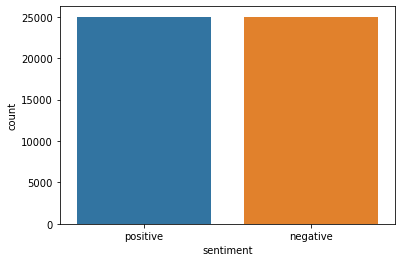

In [12]:

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

In [13]:
movie_reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [14]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [21]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.


    return sentence

In [22]:

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [23]:

X[2]


'i thought this was wonderful way to spend time on too hot summer weekend sitting in the air conditioned theater and watching light hearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer while some may be disappointed when they realize this is not match point risk addiction thought it was proof that woody allen is still fully in control of the style many of us have grown to love this was the most d laughed at one of woody comedies in years dare say decade while ve never been impressed with scarlet johanson in this she managed to tone down her sexy image and jumped right into average but spirited young woman this may not be the crown jewel of his career but it was wittier than devil wears prada and more interesting than superman great comedy to go see with friends '

In [24]:

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)



## Preparing embedding layer

In [26]:

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [27]:

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92547

In [28]:

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [29]:

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [30]:

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [31]:
embedding_matrix.shape

(92547, 100)

## Recurrent Neural Network (LSTM)

In [32]:
from keras.layers import LSTM

In [33]:

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [34]:

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         9254700   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [35]:

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=1, verbose=1, validation_split=0.2)

250/250 [==============================] - 55s 192ms/step - loss: 0.5451 - acc: 0.7203 - val_loss: 0.4612 - val_acc: 0.7844


In [36]:

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 10s 30ms/step - loss: 0.4645 - acc: 0.7870


In [37]:

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.46448978781700134
Test Accuracy: 0.7870000004768372


In [39]:

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

# Making Predictions on Live IMDb data

In [41]:

sample_reviews = pd.read_csv("IMDB UNSEEN.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [42]:

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
review = preprocess_text(review)
unseen_processed.append(review)

In [43]:

unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [44]:

unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 741ms/step


array([[0.32102814],
       [0.9283556 ],
       [0.23965703],
       [0.18940595],
       [0.91559374],
       [0.5295318 ]], dtype=float32)

In [45]:

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,3.2
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.3
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,2.4
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,1.9
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.2
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,5.3
